# Download dataset and import dependencies

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1jsewyJ1ZXRCObvJ94BrcDfgqIQ8gY3O3
!unzip flickr.zip
!rm flickr.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import os
from PIL import Image
from collections import Counter

import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [3]:
# Function that convert tensor to image and show it 
def show_image(img, title=None):
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Dataset and Dataloader

In this section, we created the dataset and dataloader for our model.   
First, we constructed the vocabulary using spacy with some pre-reserved tokens.  
We used Flickr dataset with 8k images, reshaped each image to 224x224 and normalized it. In this dataset, five captions correspond to each image, therefore the length of the final dataset is 40k samples.

In [4]:
class Vocabulary:
    spacy_eng = spacy.load("en_core_web_sm")

    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()} 
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    
    

In [5]:
class FlickrDataset(Dataset):
    def __init__(self,root,ann_file,transform=None,freq_threshold=5):
        self.root_dir = root
        self.df = pd.read_csv(ann_file)
        self.transform = transform

        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [6]:
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


In [7]:
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

dataset =  FlickrDataset(
    root = "Images",
    ann_file = "captions.txt",
    transform=transforms, 
)

In [10]:
BATCH_SIZE = 256
NUM_WORKER = 4
PAD_IDX = dataset.vocab.stoi["<PAD>"]
COLLATE_FN = CapsCollate(pad_idx=PAD_IDX,batch_first=True)


data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKER,
    collate_fn=COLLATE_FN
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model

For image captioning problem we decided to use autoencoder model with attention. 
For ecncoder we chose pretrained ResNet model, and for decoder - Bahdanau Attention Decoder. 

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    
        features = features.permute(0, 2, 3, 1)                           
        features = features.view(features.size(0), -1, features.size(-1)) 
        return features

In [12]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        self.A = nn.Linear(attention_dim,1)
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     
        w_ah = self.W(hidden_state) 

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))
        attention_scores = self.A(combined_states)         
        attention_scores = attention_scores.squeeze(2)  
        
        alpha = F.softmax(attention_scores,dim=1)        
        attention_weights = features * alpha.unsqueeze(2)  
        attention_weights = attention_weights.sum(dim=1)  
        
        return alpha,attention_weights
        

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    
    def forward(self, features, captions):

        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features) 
        seq_length = len(captions[0])-1 
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        alphas = []

        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        return [vocab.itos[idx] for idx in captions],alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c
        

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Train model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [17]:
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 loss: 4.25123


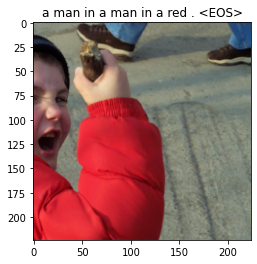

  4%|▍         | 1/25 [05:11<2:04:42, 311.78s/it]

Epoch: 1 loss: 3.58108


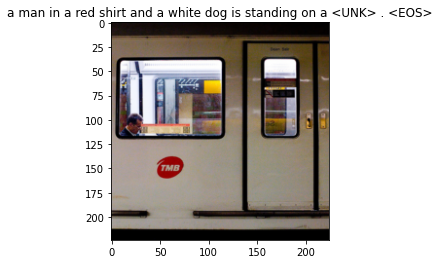

  8%|▊         | 2/25 [10:27<2:00:30, 314.36s/it]

Epoch: 2 loss: 3.34885


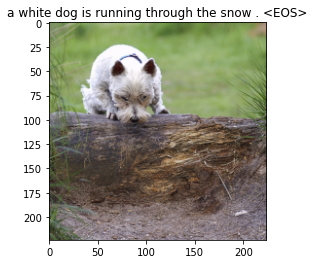

 12%|█▏        | 3/25 [15:43<1:55:27, 314.87s/it]

Epoch: 3 loss: 3.07025


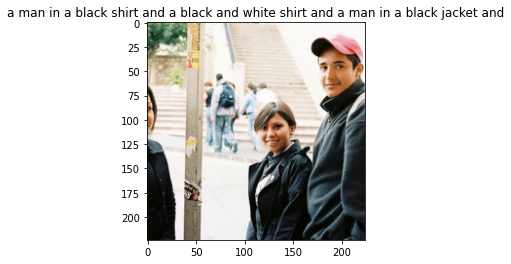

 16%|█▌        | 4/25 [21:00<1:50:26, 315.55s/it]

Epoch: 4 loss: 2.96333


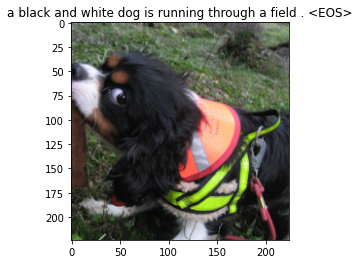

 20%|██        | 5/25 [26:14<1:45:03, 315.17s/it]

Epoch: 5 loss: 2.82261


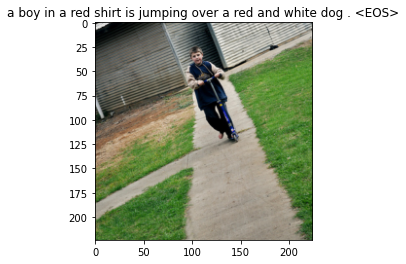

 24%|██▍       | 6/25 [31:26<1:39:26, 314.03s/it]

Epoch: 6 loss: 2.81676


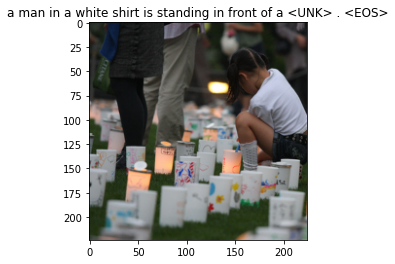

 28%|██▊       | 7/25 [36:42<1:34:24, 314.69s/it]

Epoch: 7 loss: 2.62109


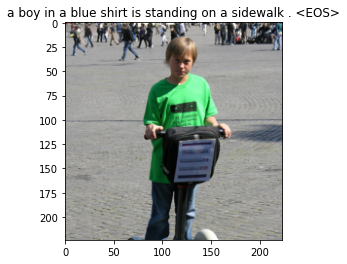

 32%|███▏      | 8/25 [41:55<1:28:58, 314.04s/it]

Epoch: 8 loss: 2.67255


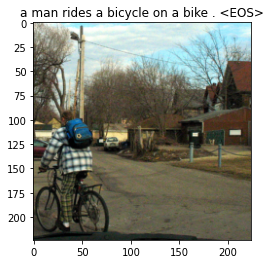

 36%|███▌      | 9/25 [47:11<1:23:55, 314.72s/it]

Epoch: 9 loss: 2.57698


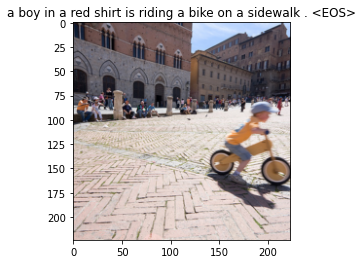

 40%|████      | 10/25 [52:28<1:18:53, 315.60s/it]

Epoch: 10 loss: 2.61784


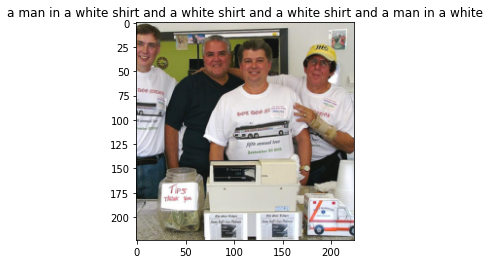

 44%|████▍     | 11/25 [57:45<1:13:43, 315.94s/it]

Epoch: 11 loss: 2.37032


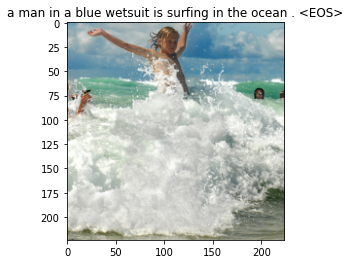

 48%|████▊     | 12/25 [1:03:02<1:08:30, 316.20s/it]

Epoch: 12 loss: 2.48685


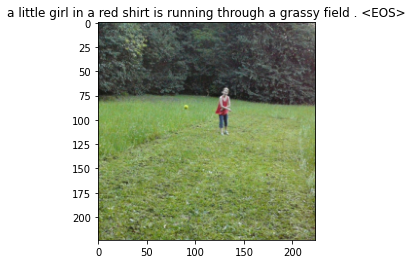

 52%|█████▏    | 13/25 [1:08:14<1:02:58, 314.89s/it]

Epoch: 13 loss: 2.37038


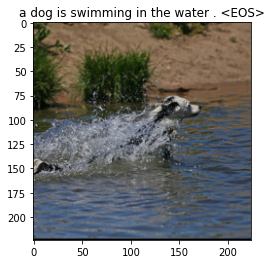

 56%|█████▌    | 14/25 [1:13:31<57:52, 315.69s/it]  

Epoch: 14 loss: 2.34082


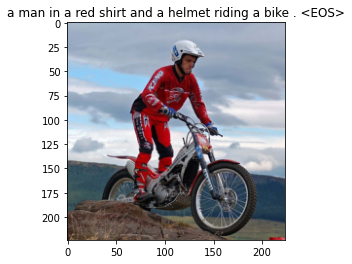

 60%|██████    | 15/25 [1:18:45<52:32, 315.22s/it]

Epoch: 15 loss: 2.26998


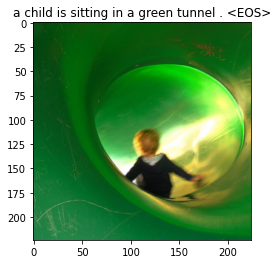

 64%|██████▍   | 16/25 [1:24:02<47:21, 315.75s/it]

Epoch: 16 loss: 2.24909


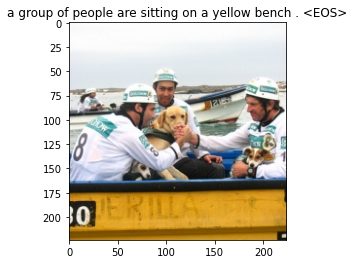

 68%|██████▊   | 17/25 [1:29:20<42:09, 316.21s/it]

Epoch: 17 loss: 2.27003


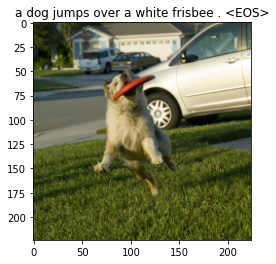

 72%|███████▏  | 18/25 [1:34:40<37:03, 317.60s/it]

Epoch: 18 loss: 2.27011


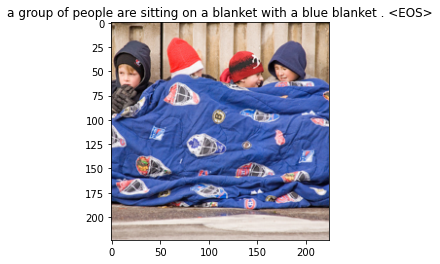

 76%|███████▌  | 19/25 [1:39:57<31:43, 317.23s/it]

Epoch: 19 loss: 2.23984


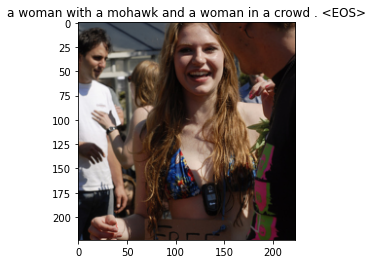

 80%|████████  | 20/25 [1:45:10<26:19, 315.90s/it]

Epoch: 20 loss: 2.19101


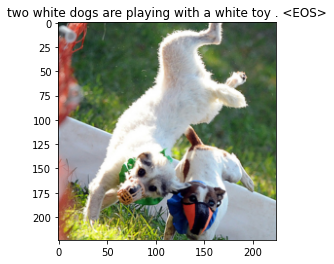

 84%|████████▍ | 21/25 [1:50:22<20:59, 314.88s/it]

Epoch: 21 loss: 2.11254


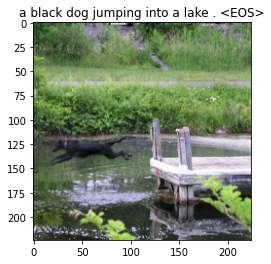

 88%|████████▊ | 22/25 [1:55:35<15:43, 314.40s/it]

Epoch: 22 loss: 2.14032


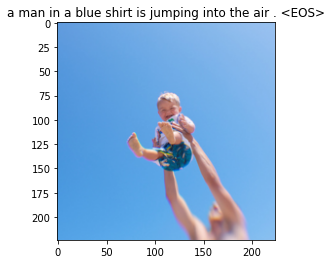

 92%|█████████▏| 23/25 [2:00:52<10:29, 314.93s/it]

Epoch: 23 loss: 2.17937


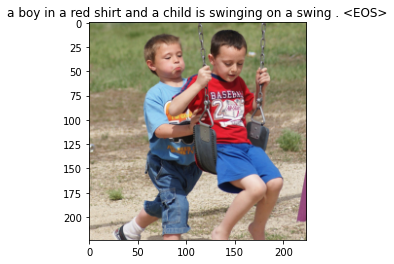

 96%|█████████▌| 24/25 [2:06:10<05:15, 315.91s/it]

Epoch: 24 loss: 2.07773


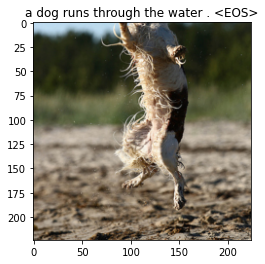

100%|██████████| 25/25 [2:11:29<00:00, 315.58s/it]


In [19]:
num_epochs = 25
print_every = 100
from tqdm import tqdm
for epoch in tqdm(range(num_epochs)):  
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)
        optimizer.zero_grad()
        outputs,attentions = model(image, captions)
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps[:-1])
                show_image(img[0],title=caption)
                
            model.train()

    save_model(model,epoch)


In [20]:
torch.save(model.state_dict(), 'captions.h5')

In [ ]:
%cp /content/captions.h5 /content/drive/MyDrive/Study/CV/captions.h5
#%cp /content/attention_model_state.pth /content/drive/MyDrive/Study/CV/attention_model_state.pth

# Evaluate model

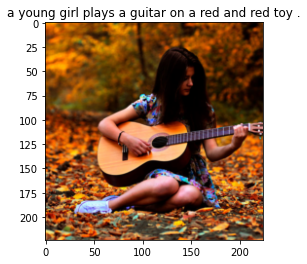

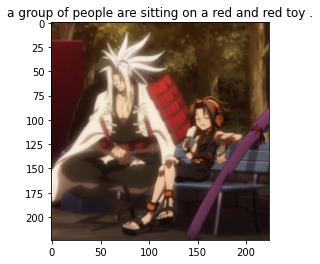

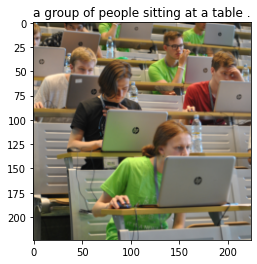

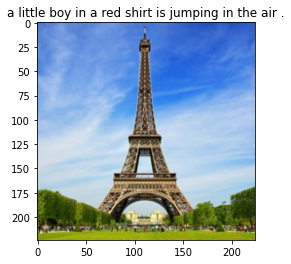

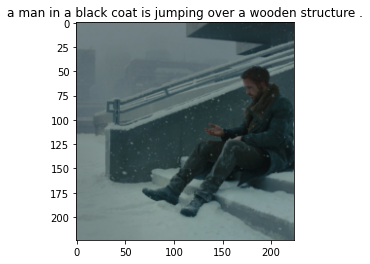

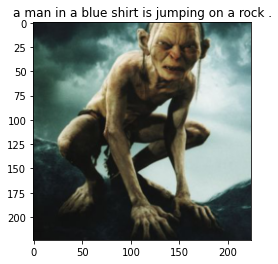

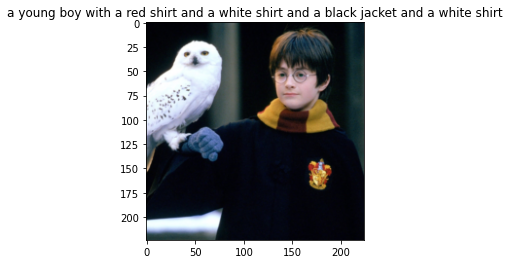

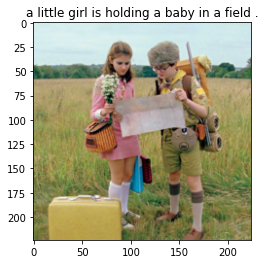

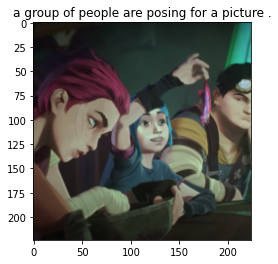

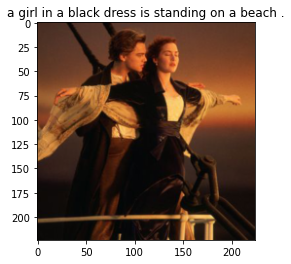

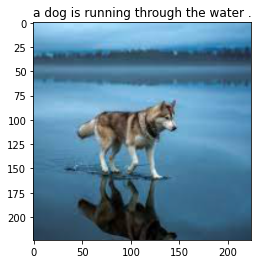

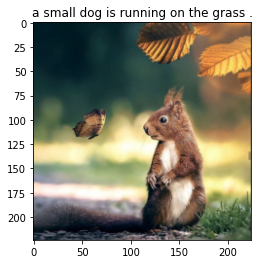

In [41]:
transforms = T.Compose([
    T.Resize(224),                     
    T.CenterCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

model.eval()
folder = '/content/test'
for img_name in os.listdir(folder):
  img_location= os.path.join(folder, img_name)
  img = Image.open(img_location).convert("RGB")
  img = transforms(img)
  with torch.no_grad():
    img = torch.reshape(img, (1, 3, 224, 224))
    features = model.encoder(img.to(device))
    caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
    caption = ' '.join(caps[:-1])
    show_image(img[0],title=caption)